## Deep Neural Artificial Intelligence for time series forecasting

In [1]:
import matplotlib
import pickle
import numpy as np     
import pandas as pd    
import seaborn as sns
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, backend
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model, register_keras_serializable, get_registered_object, get_registered_name, get_custom_objects
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors, svm, ensemble 
get_custom_objects().clear()

## CNN regressor

In [3]:
@register_keras_serializable()
class CNN_Model(Model):
    def __init__(self, input_shape):
        super(CNN_Model, self).__init__()
        self.input_shape = input_shape

        input_layer = layers.Input(shape=self.input_shape, name='input_layer')
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding="causal")(input_layer)
        x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding="causal")(x)
        x = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding="causal")(x)  
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)  
        output_layer = layers.Dense(1, activation='linear', name='output_layer')(x)
        self.model = Model(input_layer, output_layer, name='CNN_Model')

    def summary(self):
        self.model.summary()

    def call(self, x):
        CNN_Model = self.model(x)
        return CNN_Model

    def get_config(self):
        config = super(CNN_Model, self).get_config()
        config.update({
            'input_shape': self.input_shape
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop('input_shape')
        return cls(input_shape)

## LSTM regressor

In [4]:
@register_keras_serializable()
class LSTM_Model(Model):
    def __init__(self, input_shape):
        super(LSTM_Model, self).__init__()
        self.input_shape = input_shape

        input_layer = layers.Input(shape=self.input_shape, name='input_layer')
        x = layers.LSTM(units=64, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(input_layer) 
        x = layers.LSTM(units=128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(x)
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x) 
        output_layer = layers.Dense(1, activation='linear', name='output_layer')(x)
        self.model = Model(input_layer, output_layer, name='LSTM_Model')

    def summary(self):
        self.model.summary()

    def call(self, x):
        LSTM_Model = self.model(x)
        return LSTM_Model

    def get_config(self):
        config = super(LSTM_Model, self).get_config()
        config.update({
            'input_shape': self.input_shape
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop('input_shape')
        return cls(input_shape)

## CNN - LSTM in Serie

In [5]:
@register_keras_serializable()
class CNN_LSTM_Model(Model):
    def __init__(self, input_shape):
        super(CNN_LSTM_Model, self).__init__()
        self.input_shape = input_shape

        input_layer = layers.Input(shape=self.input_shape, name='input_layer')
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding="causal")(input_layer)
        x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding="causal")(x)
        x = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding="causal")(x)  
        x = layers.LSTM(units=64, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(x) 
        x = layers.LSTM(units=128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(x)
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)  
        output_layer = layers.Dense(1, activation='linear', name='output_layer')(x)
        self.model = Model(input_layer, output_layer, name='CNN_LSTM_Model')

    def summary(self):
        self.model.summary()

    def call(self, x):
        CNN_LSTM_Model = self.model(x)
        return CNN_LSTM_Model

    def get_config(self):
        config = super(CNN_LSTM_Model, self).get_config()
        config.update({
            'input_shape': self.input_shape
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop('input_shape')
        return cls(input_shape)

## CNN - LSTM parallel

In [6]:
@register_keras_serializable()
class CNN_LSTM_p_Model(Model):
    def __init__(self, input_shape):
        super(CNN_LSTM_p_Model, self).__init__()
        self.input_shape = input_shape
        
        input_layer = layers.Input(shape=self.input_shape, name='input_layer')
        # CNN path
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding="causal")(input_layer)
        x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding="causal")(x)
        x = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding="causal")(x)  
        # LSTM path
        y = layers.LSTM(units=64, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(input_layer)
        y = layers.LSTM(units=128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(y)
        # output path
        z = layers.Add()([x, y])
        z = layers.LSTM(units=64, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(z)
        z = layers.Flatten()(z)
        z = layers.Dropout(0.5)(z) 
        output_layer = layers.Dense(1, activation='linear', name='output_layer')(z)
        self.model = Model(input_layer, output_layer, name='CNN_LSTM_p_Model')

    def summary(self):
        self.model.summary()

    def call(self, x):
        CNN_LSTM_p_Model = self.model(x)
        return CNN_LSTM_p_Model

    def get_config(self):
        config = super(CNN_LSTM_p_Model, self).get_config()
        config.update({
            'input_shape': self.input_shape
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop('input_shape')
        return cls(input_shape)

## Función para entrenar los modelos

In [7]:
def train_models(escenario):
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2,  patience=25, mode='min', min_lr=1e-6, verbose=0)

    with open(f'../Pre_processing/final_train_data/escenario_{escenario}_data.pkl', 'rb') as f:
        input_shape, x_train, y_train, x_val, y_val, x_test, y_test = pickle.load(f)
    models = {
        CNN_Model(input_shape=input_shape):'CNN_model',
        LSTM_Model(input_shape=input_shape):'LSTM_model',
        CNN_LSTM_Model(input_shape=input_shape):'CNN_LSTM_model',
        CNN_LSTM_p_Model(input_shape=input_shape): 'CNN_LSTM_p_model'
    }
    total_time = 0
    for key, value in models.items():
        model = key
        model.summary()
        model.compile(loss=losses.MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])
        checkpoint_callback = ModelCheckpoint(filepath=f'{value}_{str(esc)}.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=0)
        csv_logger = CSVLogger(f'{value}_{str(esc)}_training_log.csv', append=True)
        start_time = timer()
        model.fit(x_train, y_train, batch_size=128, epochs=250, shuffle=True, verbose=0, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger, reduce_lr])
        end_time = timer()
        training_time = end_time - start_time
        print(f'Tiempo de entrenamiento en {value}: {training_time:.2f} segundos')
        total_time = total_time + training_time
    print('')
    print(f"Tiempo Total: {int(total_time // 3600)} hora con {int((total_time % 3600) // 60)} minutos y {int(total_time % 60)} segundos")

## Entrenamiento de los modelos en los dos escenarios

In [18]:
"""Entrenamiento del escenario #1"""
train_models(1)

"""Entrenamiento del escenario #2"""
train_models(2)

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 24, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 24, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 24, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,361 (200.63 KB)

 Trainable params: 51,361 (200.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_model: 258.89 segundos


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,089 (473.00 KB)

 Trainable params: 121,089 (473.00 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en LSTM_model: 1140.94 segundos


Model: "CNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 24, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 24, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 24, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,585 (779.63 KB)

 Trainable params: 199,585 (779.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_LSTM_model: 1418.93 segundos


Model: "CNN_LSTM_p_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 24, 10)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_6 (Conv1D)             │ (None, 24, 32)            │             992 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)             │ (None, 24, 64)            │           6,208 │ conv1d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 24, 64)            │          19,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 24, 128)           │          41,088 │ conv1d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 24, 128)           │          98,816 │ lstm_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 24, 128)           │               0 │ conv1d_8[0][0],            │
│                               │                           │                 │ lstm_5[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 24, 64)            │          49,408 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 1536)              │               0 │ lstm_6[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 1536)              │               0 │ flatten_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_layer (Dense)          │ (None, 1)                 │           1,537 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 217,249 (848.63 KB)

 Trainable params: 217,249 (848.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_LSTM_p_model: 1639.29 segundos

Tiempo Total: 1 hora con 14 minutos y 18 segundos


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 24, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 24, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 24, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,361 (200.63 KB)

 Trainable params: 51,361 (200.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_model: 288.90 segundos


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 24, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,089 (473.00 KB)

 Trainable params: 121,089 (473.00 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en LSTM_model: 1081.19 segundos


Model: "CNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 24, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 24, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 24, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 24, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           3,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,585 (779.63 KB)

 Trainable params: 199,585 (779.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_LSTM_model: 1416.20 segundos


Model: "CNN_LSTM_p_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 24, 10)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_15 (Conv1D)            │ (None, 24, 32)            │             992 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_16 (Conv1D)            │ (None, 24, 64)            │           6,208 │ conv1d_15[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_11 (LSTM)                │ (None, 24, 64)            │          19,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_17 (Conv1D)            │ (None, 24, 128)           │          41,088 │ conv1d_16[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_12 (LSTM)                │ (None, 24, 128)           │          98,816 │ lstm_11[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 24, 128)           │               0 │ conv1d_17[0][0],           │
│                               │                           │                 │ lstm_12[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_13 (LSTM)                │ (None, 24, 64)            │          49,408 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_7 (Flatten)           │ (None, 1536)              │               0 │ lstm_13[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 1536)              │               0 │ flatten_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_layer (Dense)          │ (None, 1)                 │           1,537 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 217,249 (848.63 KB)

 Trainable params: 217,249 (848.63 KB)

 Non-trainable params: 0 (0.00 B)

Tiempo de entrenamiento en CNN_LSTM_p_model: 1834.15 segundos

Tiempo Total: 1 hora con 17 minutos y 0 segundos


## Función para evaluación por unidad por set

In [8]:
def Scaler(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    features = np.array(df_scaled[:, :-1]) 
    target = np.array(df_scaled[:,-1])
    return [features, target, scaler]

def Sliding_Window(features, target, win_length):    
    ts_generator = TimeseriesGenerator(features, target, length=win_length, sampling_rate=1, batch_size=1) 
    X=[]
    y=[]
    for i in range(len(ts_generator)):
        x_temp, y_temp = ts_generator[i]
        X.append(x_temp.reshape(x_temp.shape[1], x_temp.shape[2], 1))
        y.append(y_temp)
    X=np.array(X)  
    y=np.array(y)
    return [X, y]

def evaluation_per_unit(model, df):
    units = df['unit_id'].unique()
    num_units = len(units)
    if num_units % 3 == 0:
        rows, cols = num_units // 3, 3
    elif num_units == 4:
        rows, cols = 2, 2
    else:
        rows = (num_units // 3) + 1
        cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    axes = axes.flatten()
    
    for i, unit in enumerate(units):
        unit_data = df[df['unit_id']==unit].iloc[:, 2:]
        features, target, scaler = Scaler(unit_data)
        x, y = Sliding_Window(features, target, win_length)
        y_pred = model.predict(x)
        
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        
        df_actual = unit_data.iloc[win_length:, :].reset_index(drop=True)
        rev_trans = pd.concat([pd.DataFrame(features[win_length:]), pd.DataFrame(y_pred)], axis=1)
        rev_trans = scaler.inverse_transform(rev_trans)
        rev_trans = pd.DataFrame(rev_trans, columns=df_actual.columns.to_list())

        ax = axes[i]
        ax.plot(df_actual['RUL'], label='Actual RUL')
        ax.plot(rev_trans['RUL'], label='Predicted RUL')
        ax.set_title(f'Unit {unit} - Actual vs Predicted RUL')
        ax.set_xlabel('Time')
        ax.set_ylabel('RUL')
        ax.legend()
        ax.grid(True)
        
        text_box = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.375, text_box, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

## Función para visualización de training history & residuals

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(8, 3))
    plt.plot(history['epoch'], history['loss'], label='Training Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, set_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 2))
    plt.scatter(range(len(residuals)), residuals, alpha=0.6, s=10)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title(f'Residuals of Predictions - {set_name} Set')
    plt.grid(True)
    plt.show()

## Evaluación del Modelo Convolucional (CNN_model)

In [10]:
# Evaluación del modelo Convolucional (CNN_model) 
CNN_model = load_model('models/CNN_model_1.keras')
with open('../Pre_processing/final_train_data/escenario_1_data.pkl', 'rb') as f:
    input_shape, x_train, y_train, x_val, y_val, x_test, y_test = pickle.load(f)

y_pred_train = CNN_model.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)
print('PREDICTION ON TRAINING SET')
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print('')

y_pred_val = CNN_model.predict(x_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_r2 = r2_score(y_val, y_pred_val)
print('PREDICTION ON VALIDATION SET')
print(f"Val MSE: {val_mse:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Val R2: {val_r2:.4f}")
print('')

y_pred_test = CNN_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print('PREDICTION ON TESTING SET')
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")


283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
PREDICTION ON TRAINING SET
Train MSE: 0.0009
Train MAE: 0.0207
Train RMSE: 0.0308
Train R2: 0.9914

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
PREDICTION ON VALIDATION SET
Val MSE: 0.0033
Val MAE: 0.0337
Val RMSE: 0.0573
Val R2: 0.9698

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
PREDICTION ON TESTING SET
Test MSE: 0.0036
Test MAE: 0.0414
Test RMSE: 0.0604
Test R2: 0.9669


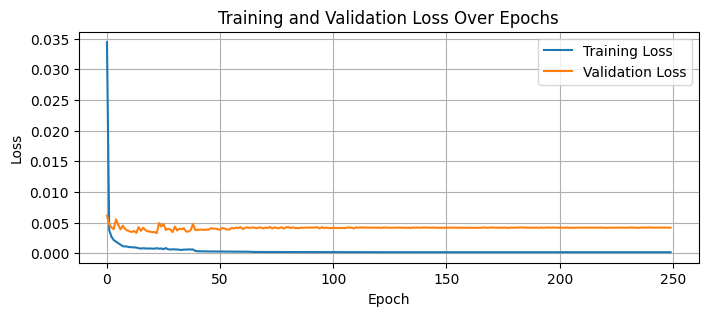

In [11]:
# Cargar el training log
history_cnn = pd.read_csv('train_logs/CNN_model_1_training_log.csv')
plot_training_history(history_cnn)

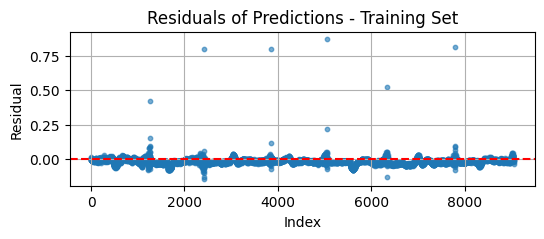

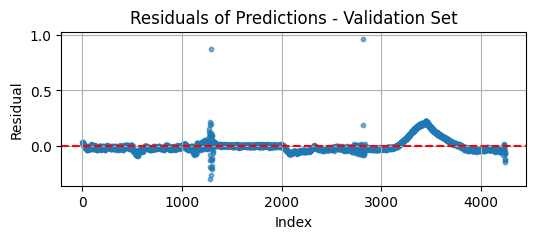

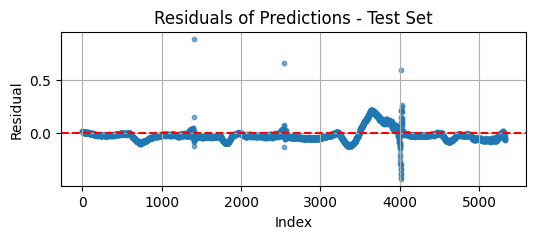

In [12]:
# Residuals on all sets
plot_residuals(y_train, y_pred_train, 'Training')
plot_residuals(y_val, y_pred_val, 'Validation')
plot_residuals(y_test, y_pred_test, 'Test')

## Evaluación Modelo CNN en unidades de entrenamiento

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


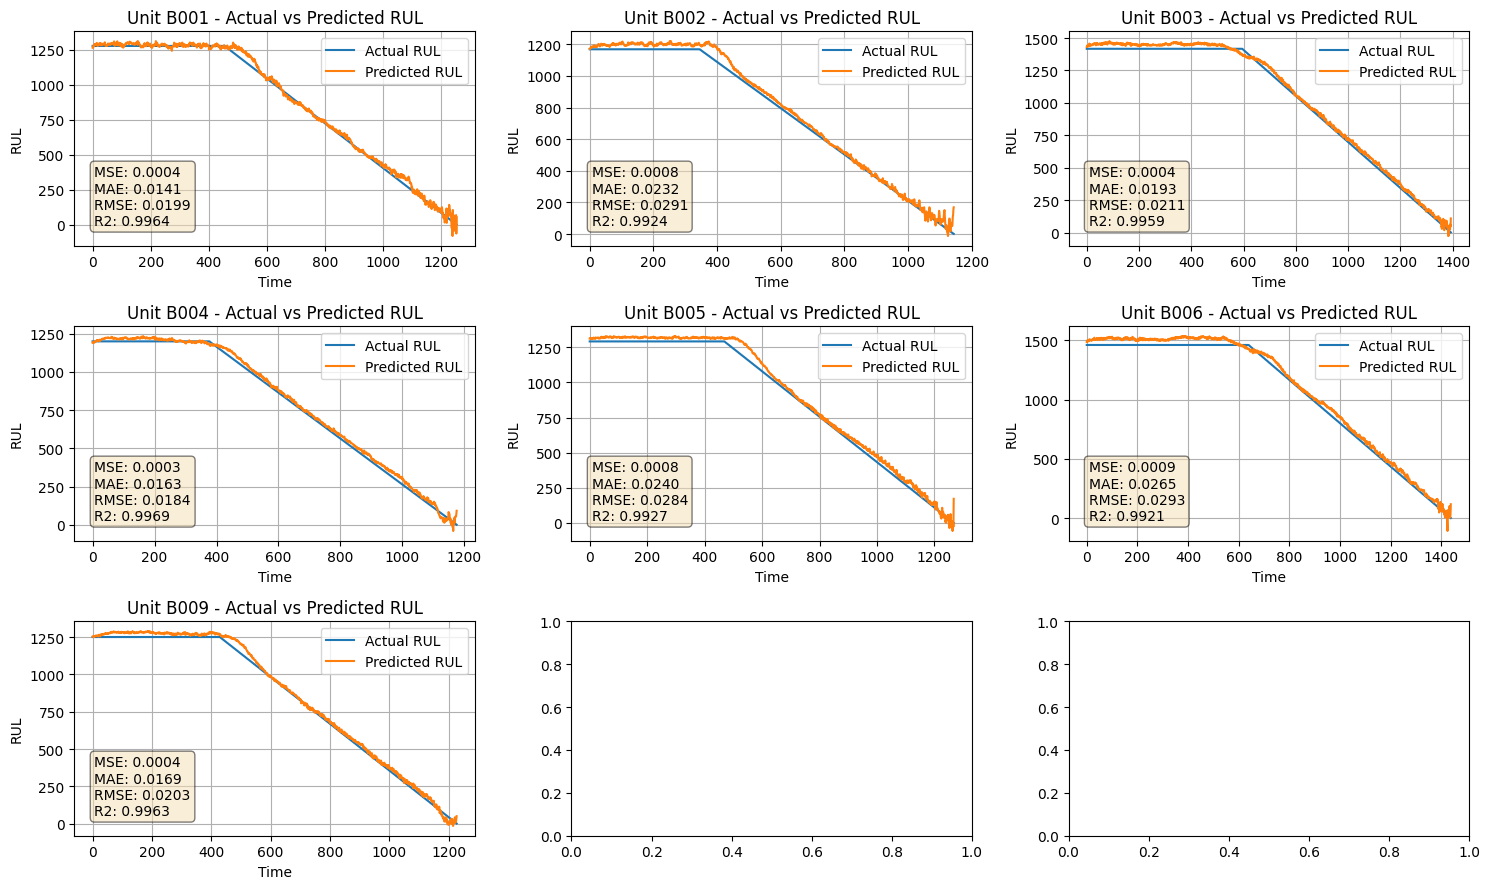

In [13]:
df = pd.read_pickle('../Pre_processing/resized_data.pkl')
escenarios = {
    1:{
        'train_units':['B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B009'], 
        'val_units':['B010', 'B011', 'B012'], 
        'test_units':['B007', 'B008', 'B013', 'B014']
    }, 
    2:{
        'train_units':['B001', 'B003', 'B004', 'B006', 'B007', 'B010', 'B012', 'B013'], 
        'val_units':['B002', 'B011'], 
        'test_units':['B005', 'B008', 'B009', 'B014']
    }
}
win_length = 24
train_units = df[df['unit_id'].isin(escenarios[1]['train_units'])].reset_index(drop=True)
evaluation_per_unit(CNN_model, train_units)

## Evaluación Modelo CNN en unidades de validación

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


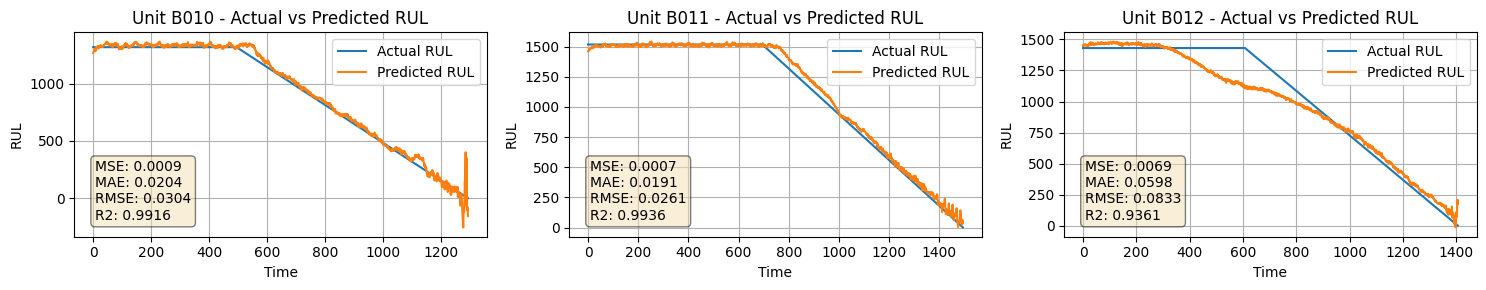

In [14]:
win_length = 24
val_units = df[df['unit_id'].isin(escenarios[1]['val_units'])].reset_index(drop=True)
evaluation_per_unit(CNN_model, val_units)

## Evaluación Modelo CNN en unidades de prueba

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


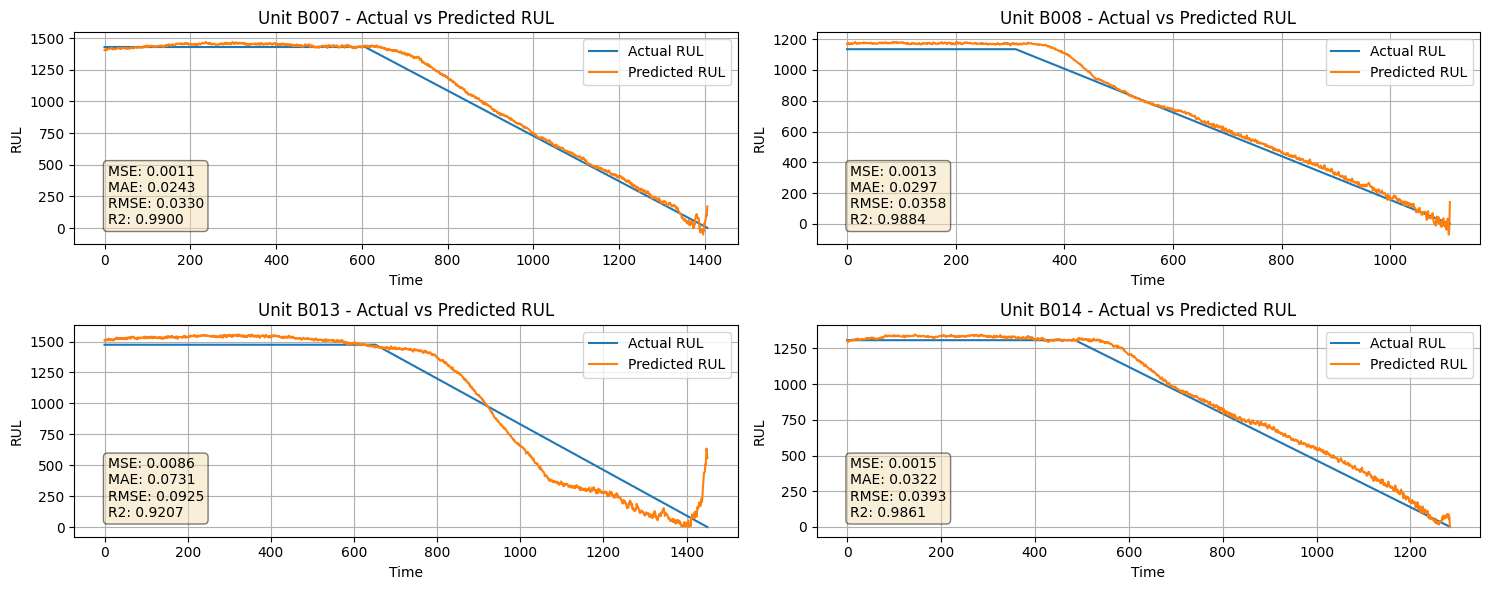

In [15]:
win_length = 24
test_units = df[df['unit_id'].isin(escenarios[1]['test_units'])].reset_index(drop=True)
evaluation_per_unit(CNN_model, test_units)

## Evaluación del Modelo Long Short-Term Memory (LSTM_model)

In [16]:
# Evaluación del modelo Long Short-Term Memory (LSTM_model) 
LSTM_model = load_model('models/LSTM_model_1.keras')

y_pred_train = LSTM_model.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)
print('PREDICTION ON TRAINING SET')
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print('')

y_pred_val = LSTM_model.predict(x_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_r2 = r2_score(y_val, y_pred_val)
print('PREDICTION ON VALIDATION SET')
print(f"Val MSE: {val_mse:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Val R2: {val_r2:.4f}")
print('')

y_pred_test = LSTM_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print('PREDICTION ON TESTING SET')
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")

283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
PREDICTION ON TRAINING SET
Train MSE: 0.0013
Train MAE: 0.0184
Train RMSE: 0.0364
Train R2: 0.9880

133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
PREDICTION ON VALIDATION SET
Val MSE: 0.0027
Val MAE: 0.0331
Val RMSE: 0.0519
Val R2: 0.9752

167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
PREDICTION ON TESTING SET
Test MSE: 0.0021
Test MAE: 0.0307
Test RMSE: 0.0461
Test R2: 0.9807


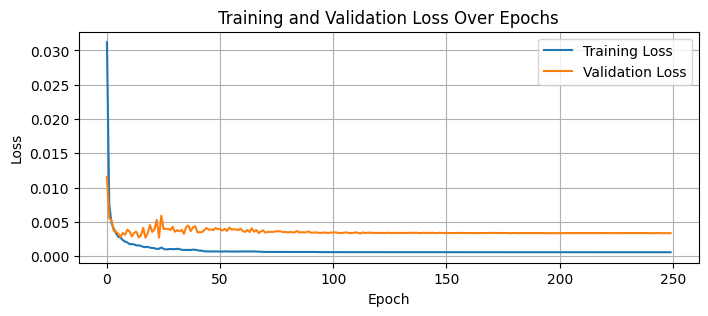

In [17]:
# Cargar el training log
history_lstm = pd.read_csv('train_logs/LSTM_model_1_training_log.csv')
plot_training_history(history_lstm)

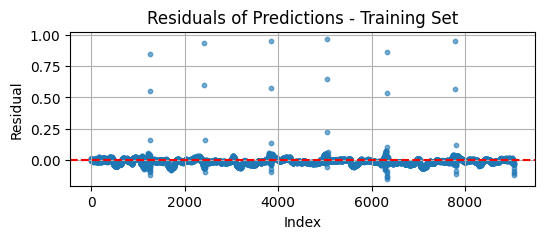

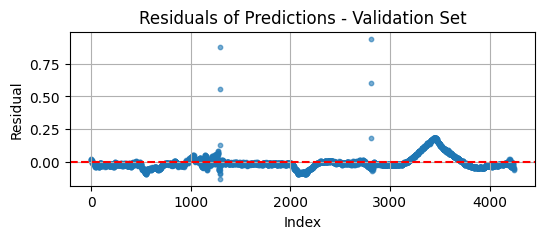

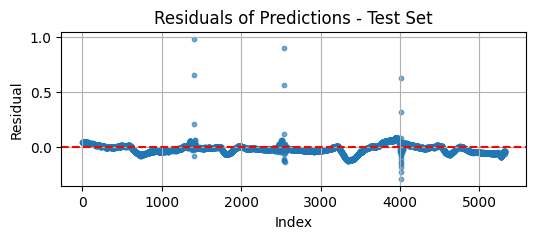

In [18]:
# Residuals on all sets
plot_residuals(y_train, y_pred_train, 'Training')
plot_residuals(y_val, y_pred_val, 'Validation')
plot_residuals(y_test, y_pred_test, 'Test')

## Evaluación Modelo LSTM en unidades de entrenamiento

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


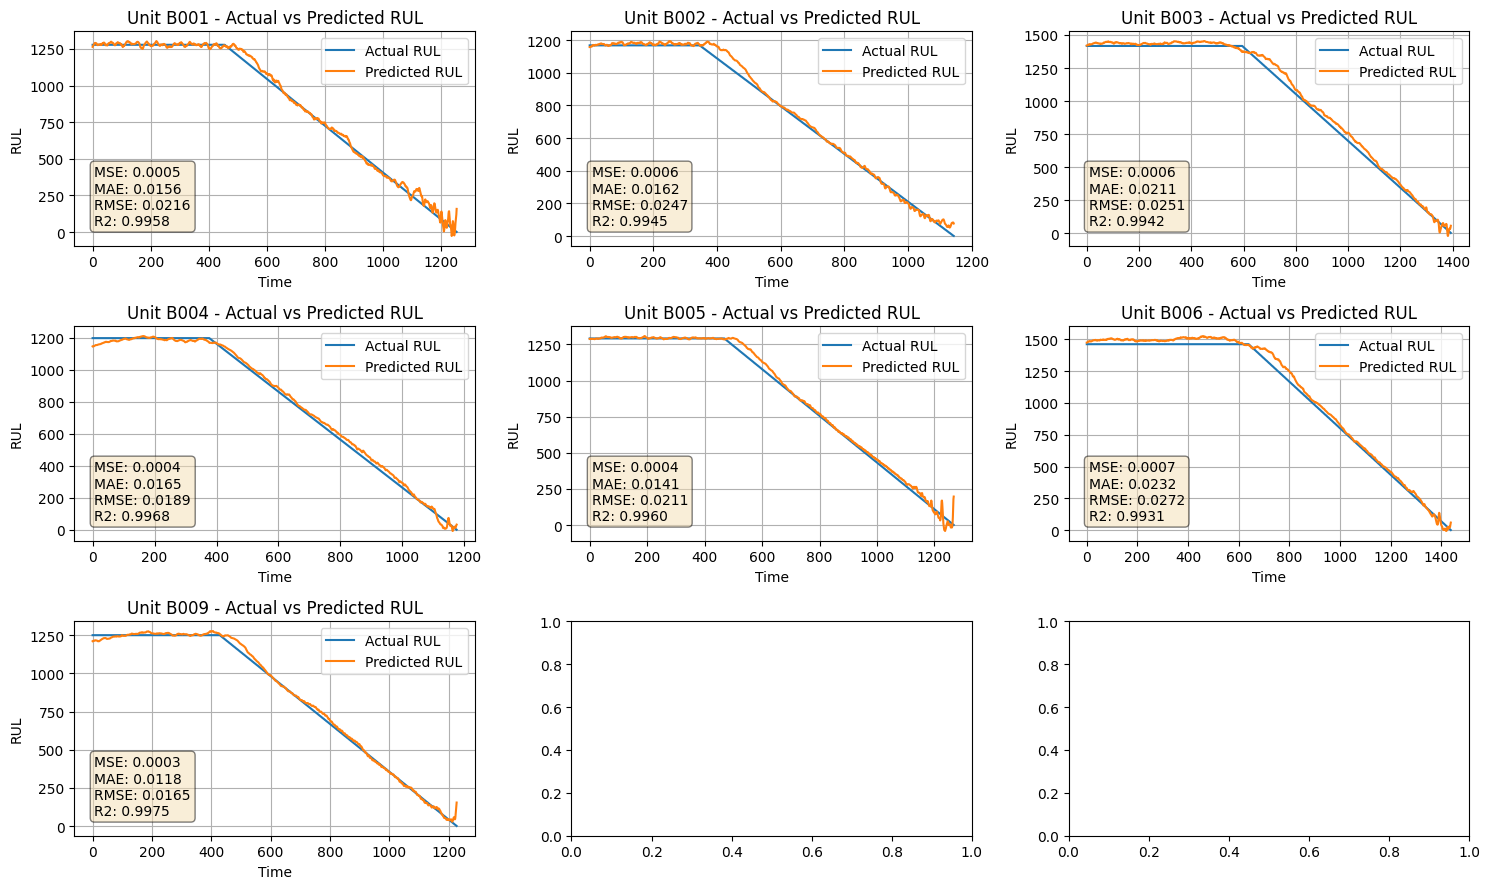

In [19]:
evaluation_per_unit(LSTM_model, train_units)

## Evaluación Modelo LSTM en datos de validación

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


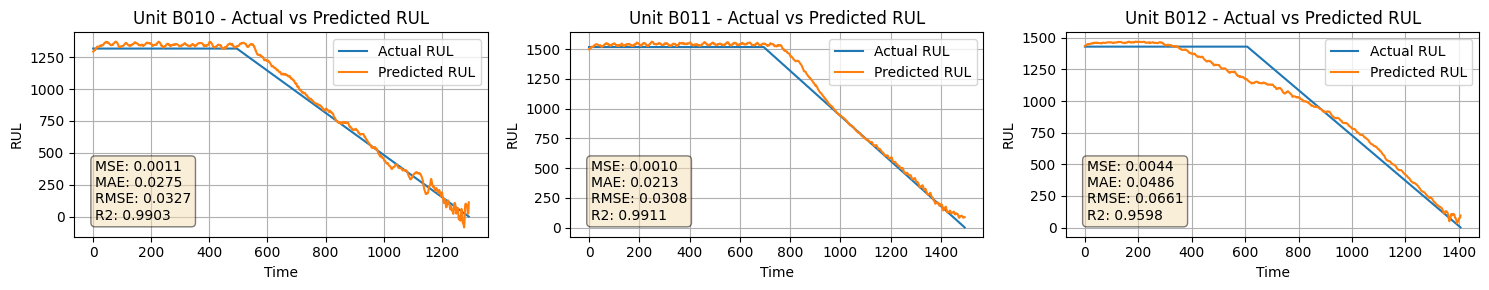

In [20]:
evaluation_per_unit(LSTM_model, val_units)

## Evaluación Modelo LSTM en datos de prueba

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


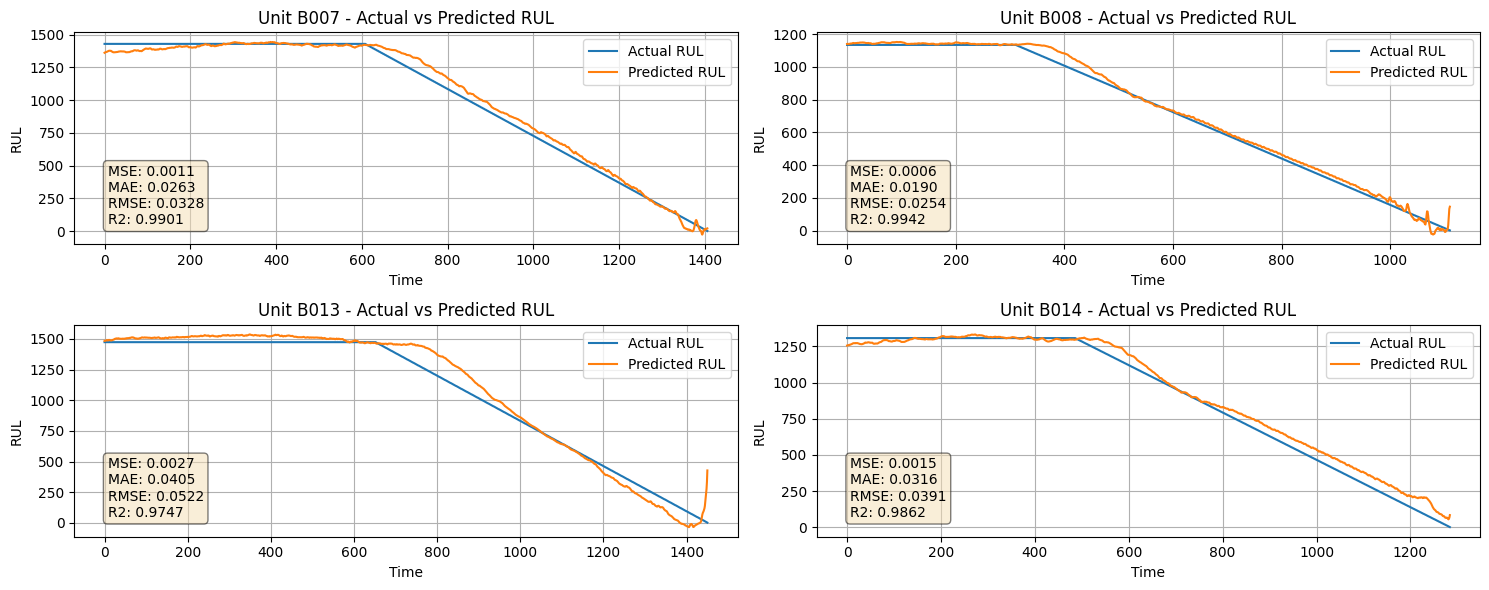

In [21]:
evaluation_per_unit(LSTM_model, test_units)

## Evaluación del Modelo en serie Convolucional - LSTM (CNN_LSTM_model)

In [22]:
# Evaluación del modelo CNN_LSTM (CNN_LSTM_model) 
CNN_LSTM_model = load_model('models/CNN_LSTM_model_1.keras')

y_pred_train = CNN_LSTM_model.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)
print('PREDICTION ON TRAINING SET')
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print('')

y_pred_val = CNN_LSTM_model.predict(x_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_r2 = r2_score(y_val, y_pred_val)
print('PREDICTION ON VALIDATION SET')
print(f"Val MSE: {val_mse:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Val R2: {val_r2:.4f}")
print('')

y_pred_test = CNN_LSTM_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print('PREDICTION ON TESTING SET')
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")

283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
PREDICTION ON TRAINING SET
Train MSE: 0.0006
Train MAE: 0.0148
Train RMSE: 0.0247
Train R2: 0.9945

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
PREDICTION ON VALIDATION SET
Val MSE: 0.0028
Val MAE: 0.0337
Val RMSE: 0.0525
Val R2: 0.9746

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
PREDICTION ON TESTING SET
Test MSE: 0.0019
Test MAE: 0.0293
Test RMSE: 0.0436
Test R2: 0.9828


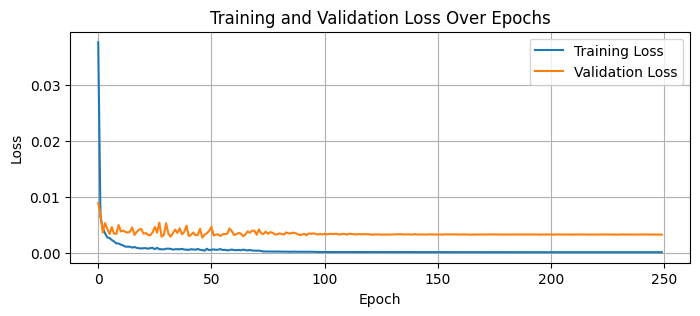

In [23]:
# Cargar el training log
history_cnn_lstm = pd.read_csv('train_logs/CNN_LSTM_model_1_training_log.csv')
plot_training_history(history_cnn_lstm)

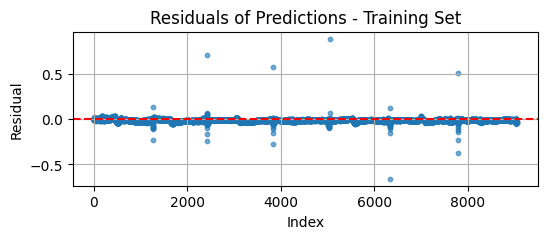

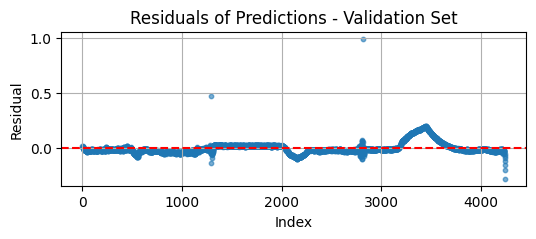

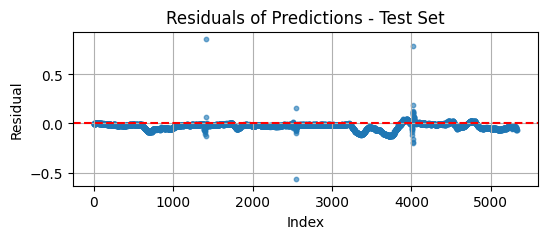

In [24]:
# Residuals on all sets
plot_residuals(y_train, y_pred_train, 'Training')
plot_residuals(y_val, y_pred_val, 'Validation')
plot_residuals(y_test, y_pred_test, 'Test')

## Evaluación Modelo CNN_LSTM en unidades de entrenamiento

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


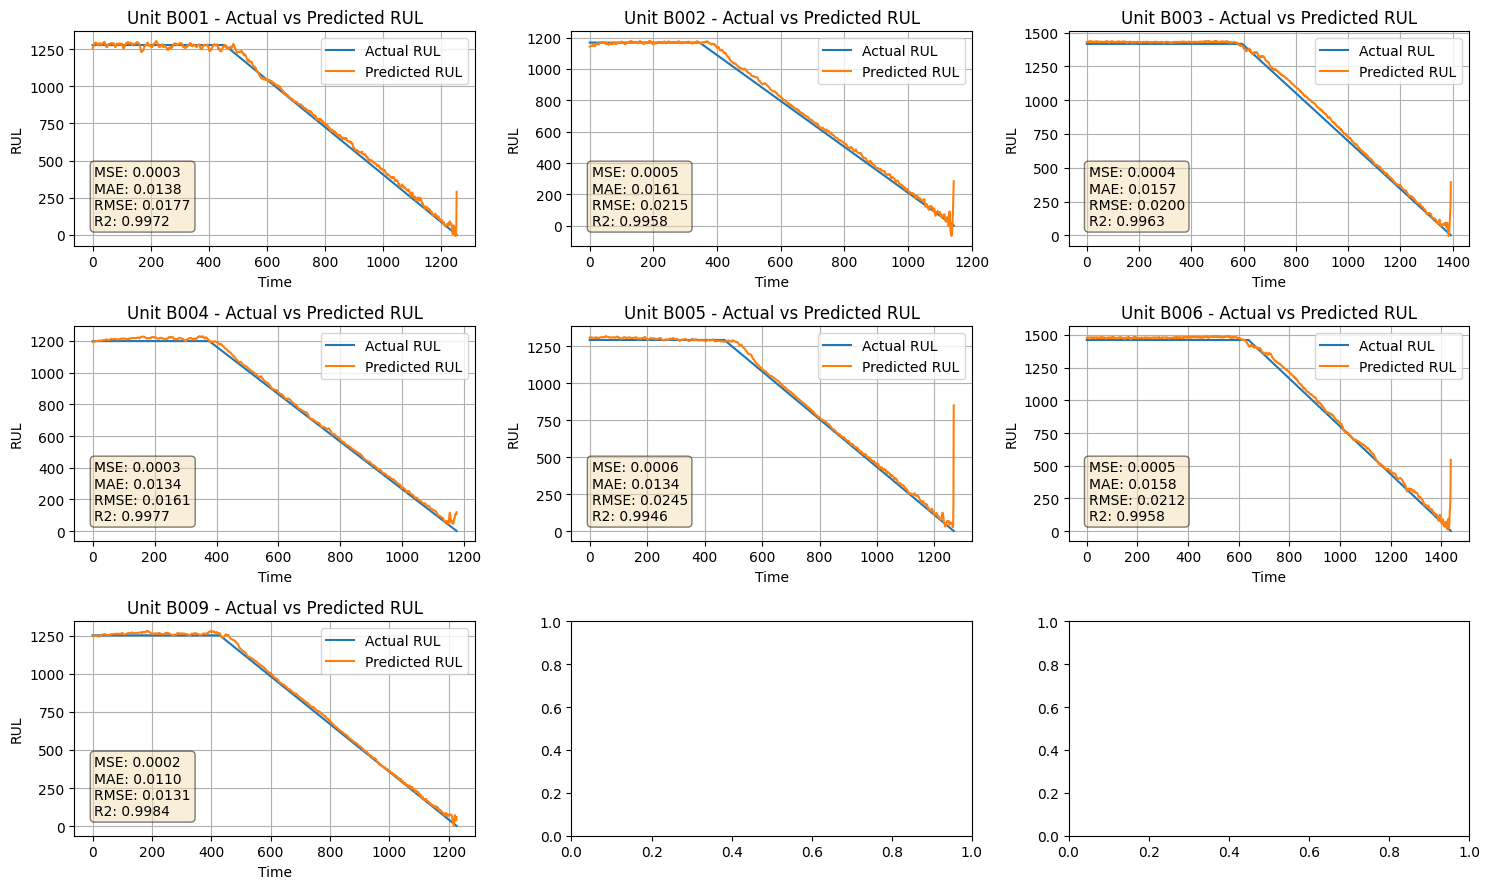

In [25]:
evaluation_per_unit(CNN_LSTM_model, train_units)

## Evaluación Modelo CNN_LSTM en unidades de validación

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


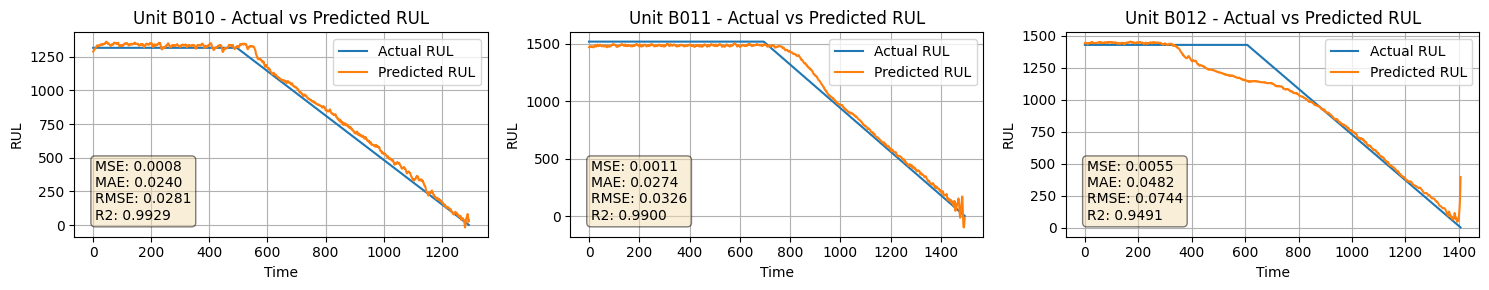

In [26]:
evaluation_per_unit(CNN_LSTM_model, val_units)

## Evaluación Modelo CNN_LSTM en unidades de prueba

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


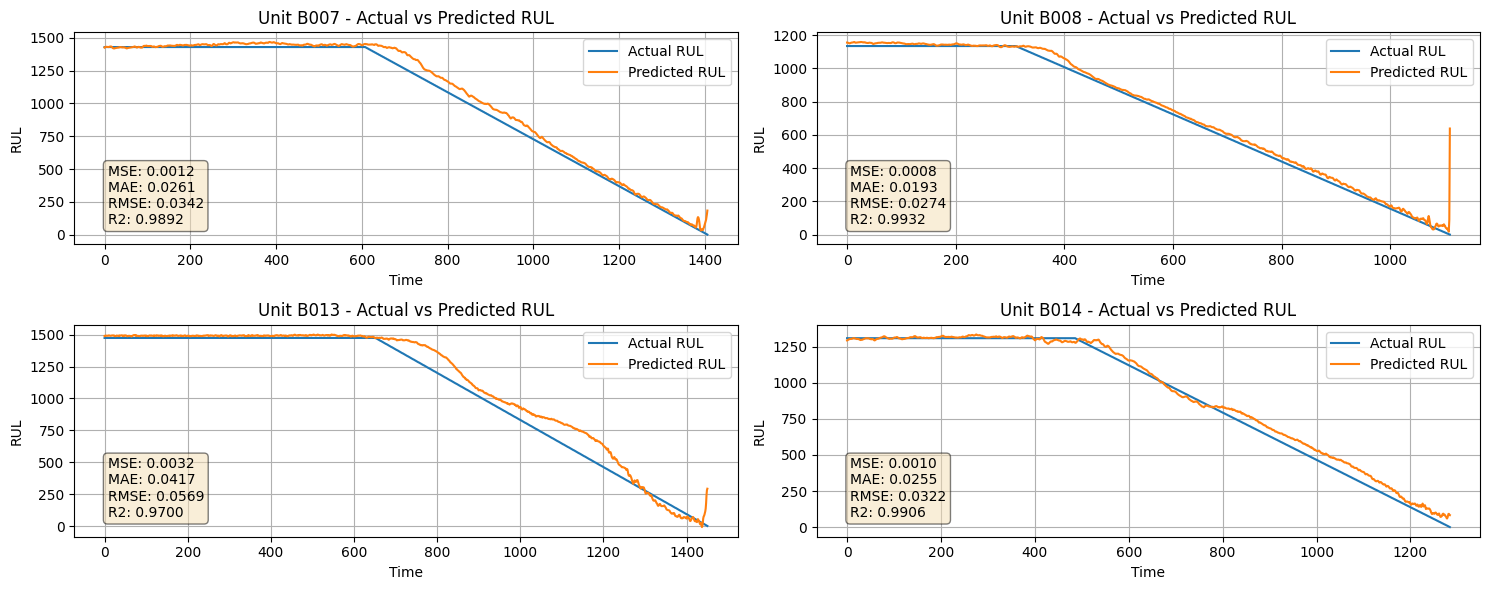

In [27]:
evaluation_per_unit(CNN_LSTM_model, test_units)

## Evaluación del Modelo en paralelo Convolucional - LSTM (CNN_LSTM_p_model)

In [28]:
# Evaluación del modelo CNN_LSTM en paralelo (CNN_LSTM_p_model) 
CNN_LSTM_p_model = load_model('models/CNN_LSTM_p_model_1.keras')

y_pred_train = CNN_LSTM_p_model.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)
print('PREDICTION ON TRAINING SET')
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print('')

y_pred_val = CNN_LSTM_p_model.predict(x_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_r2 = r2_score(y_val, y_pred_val)
print('PREDICTION ON VALIDATION SET')
print(f"Val MSE: {val_mse:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Val R2: {val_r2:.4f}")
print('')

y_pred_test = CNN_LSTM_p_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print('PREDICTION ON TESTING SET')
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")

283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
PREDICTION ON TRAINING SET
Train MSE: 0.0009
Train MAE: 0.0158
Train RMSE: 0.0307
Train R2: 0.9915

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
PREDICTION ON VALIDATION SET
Val MSE: 0.0026
Val MAE: 0.0289
Val RMSE: 0.0510
Val R2: 0.9761

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
PREDICTION ON TESTING SET
Test MSE: 0.0018
Test MAE: 0.0268
Test RMSE: 0.0425
Test R2: 0.9836


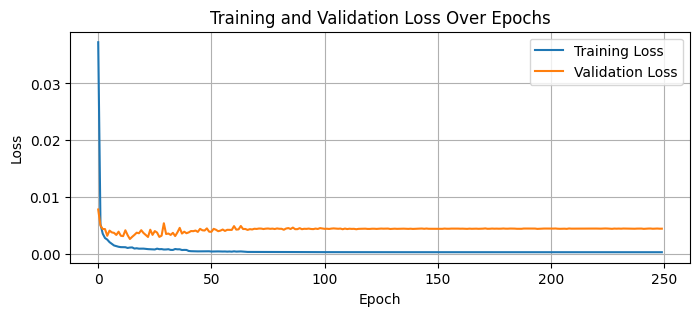

In [29]:
# Cargar el training log
history_cnn_lstm_p = pd.read_csv('train_logs/CNN_LSTM_p_model_1_training_log.csv')
plot_training_history(history_cnn_lstm_p)

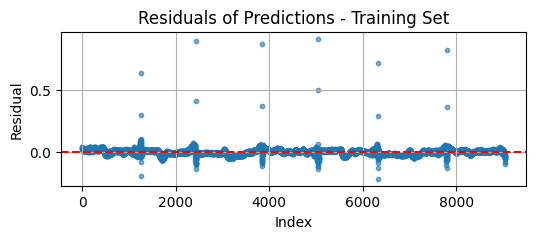

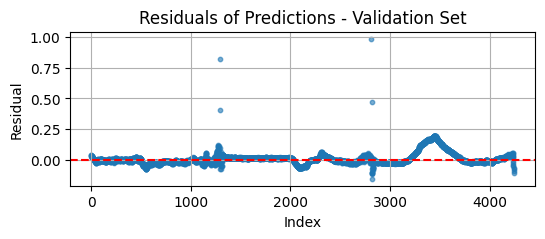

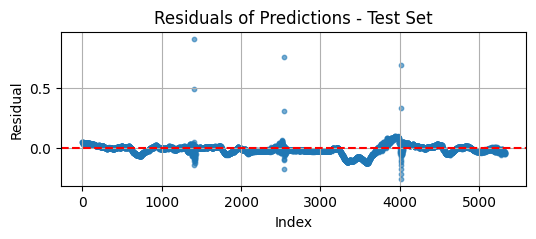

In [30]:
# Residuals on all sets
plot_residuals(y_train, y_pred_train, 'Training')
plot_residuals(y_val, y_pred_val, 'Validation')
plot_residuals(y_test, y_pred_test, 'Test')

## Evaluación Modelo CNN_LSTM_p en datos de entrenamiento

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


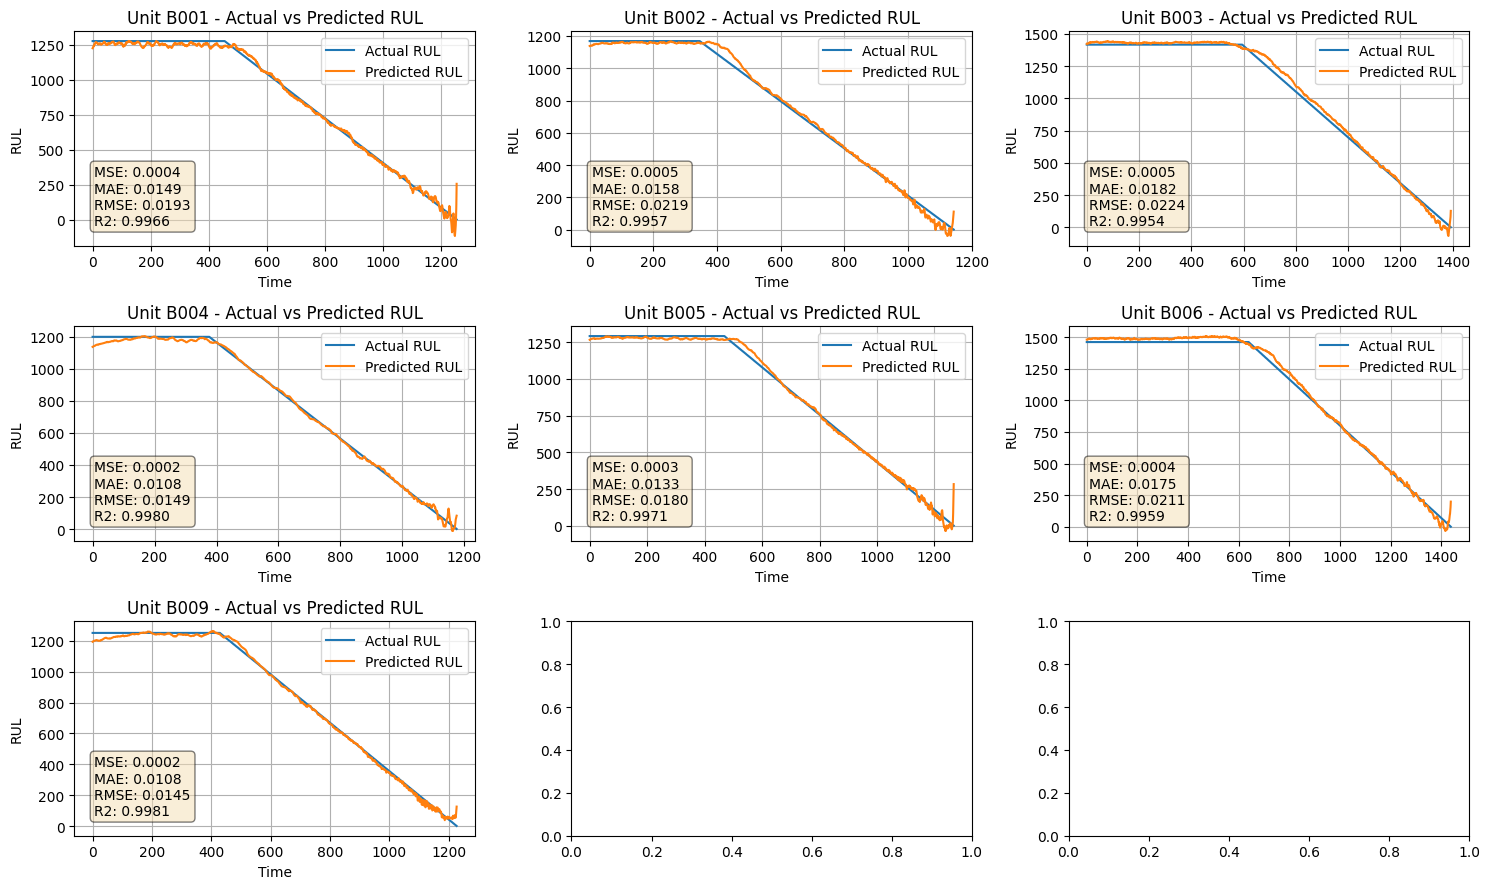

In [31]:
evaluation_per_unit(CNN_LSTM_p_model, train_units)

## Evaluación Modelo CNN_LSTM_p en datos de validación

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


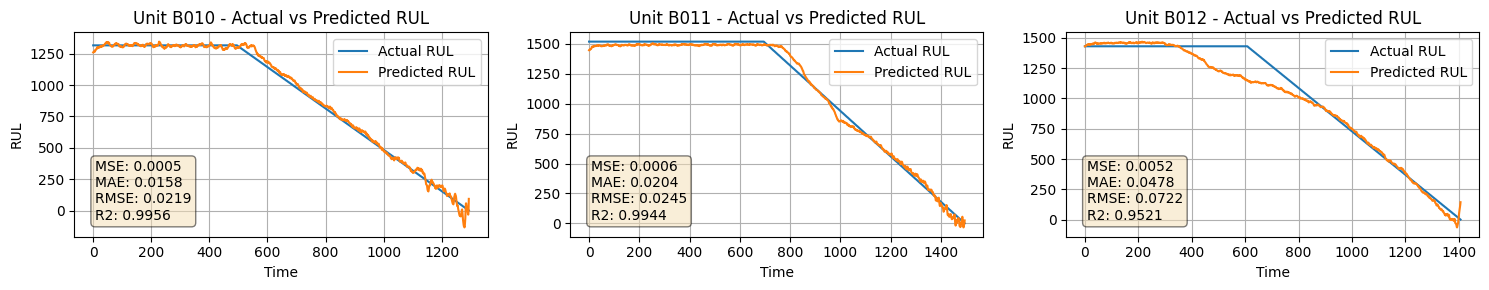

In [32]:
evaluation_per_unit(CNN_LSTM_p_model, val_units)

## Evaluación Modelo CNN_LSTM_p en datos de prueba

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


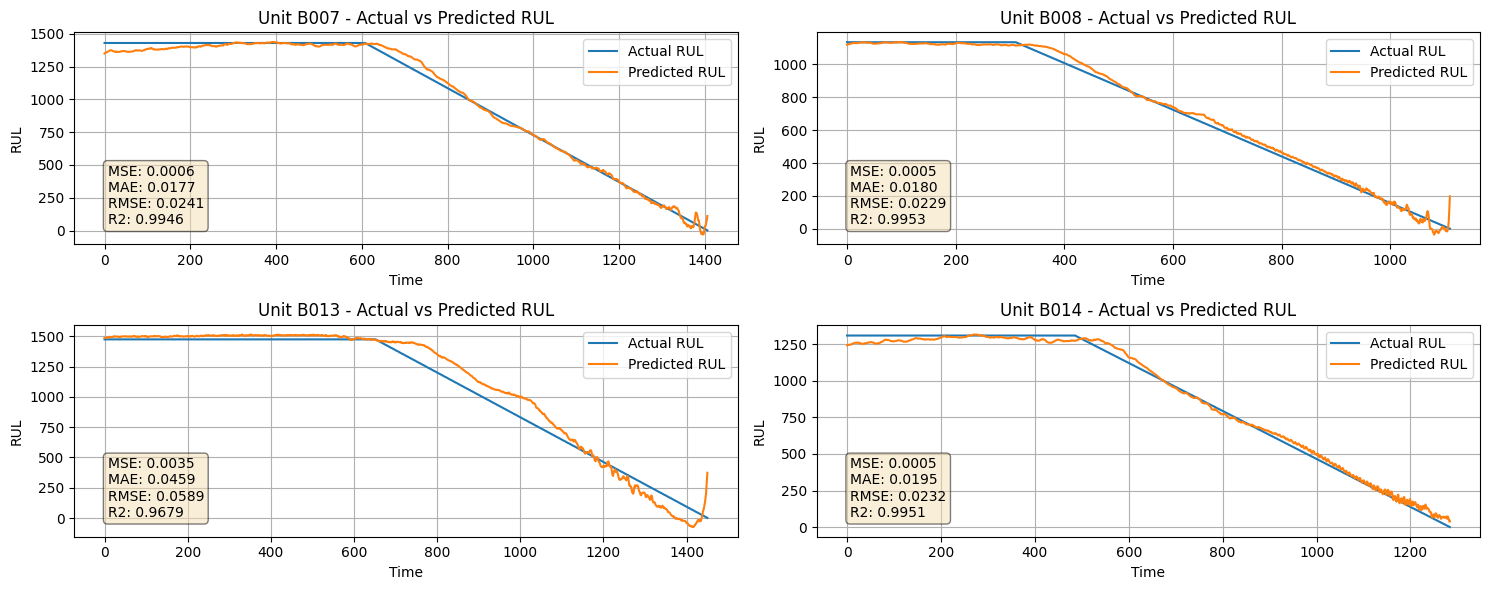

In [33]:
evaluation_per_unit(CNN_LSTM_p_model, test_units)

## Evaluación de los todos los modelos por unidad por escenario

In [51]:
def evaluation_model(df, unit, esc, end):
    models = {
        CNN_model:'CNN_model',
        LSTM_model:'LSTM_model',
        CNN_LSTM_model:'CNN_LSTM_model',
        CNN_LSTM_p_model: 'CNN_LSTM_p_model'
    }

    unit_data = df[df['unit_id']==unit].iloc[:, 2:]
    features, target, scaler = Scaler(unit_data)
    x, y = Sliding_Window(features, target, win_length)
    df_actual = unit_data.reset_index(drop=True)
    
    plt.figure(figsize=(6, 5))
    plt.plot(df_actual['RUL'], '--', label='Actual RUL', linewidth=1.5)
    
    for model in models:
        y_pred = model.predict(x)
        rev_trans = pd.concat([pd.DataFrame(features[win_length:]), pd.DataFrame(y_pred)], axis=1)
        rev_trans = scaler.inverse_transform(rev_trans)
        rev_trans = pd.DataFrame(rev_trans, columns=df_actual.columns.to_list())
        rev_trans.index = pd.RangeIndex(start=win_length, stop=len(df_actual))
        plt.plot(rev_trans['RUL'], label=f'{models[model]} prediction', linewidth=1.2)
        
    plt.title(f'Unit {unit} - Actual vs Predicted RUL')
    plt.xlabel('Time (hours)')
    plt.ylabel('RUL (hours)')
    plt.xlim(0, end+24)
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.savefig(f'images/Pred_results_{str(esc)}_{unit}.png', format='png', dpi=300)  
    plt.show()

Para evaluar cada uno de los escenarios, sólo hay que cambiar el valor de la variable ``escenario`` a ``1`` o a ``2`` dependiendo del caso

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TRAIN UNITS
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


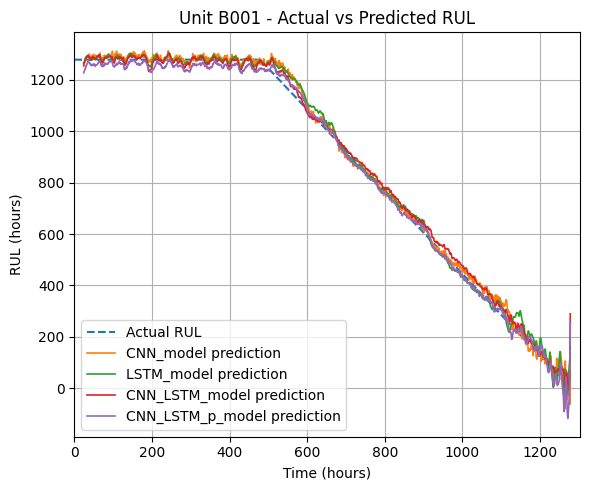

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


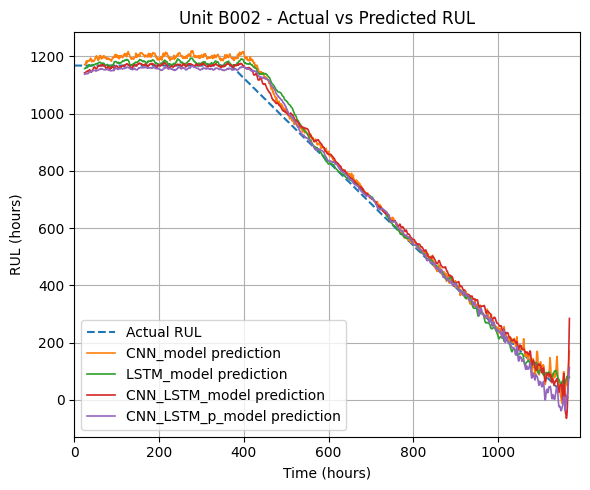

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


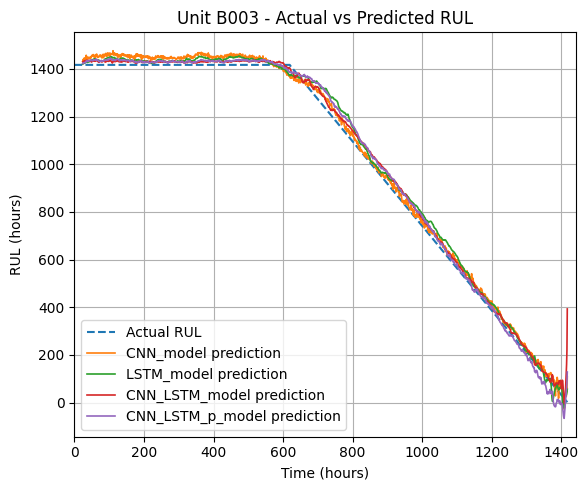

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


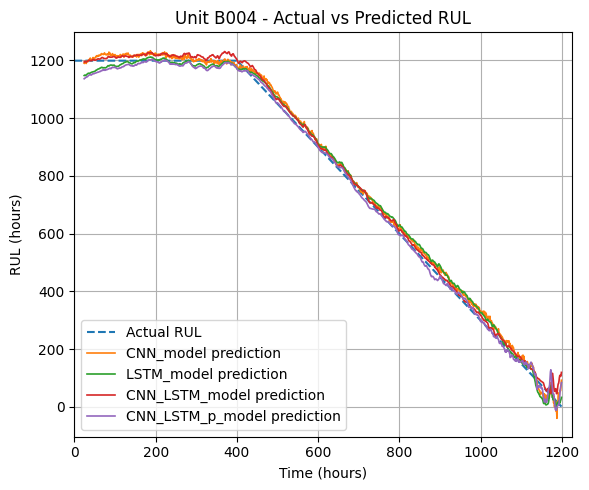

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


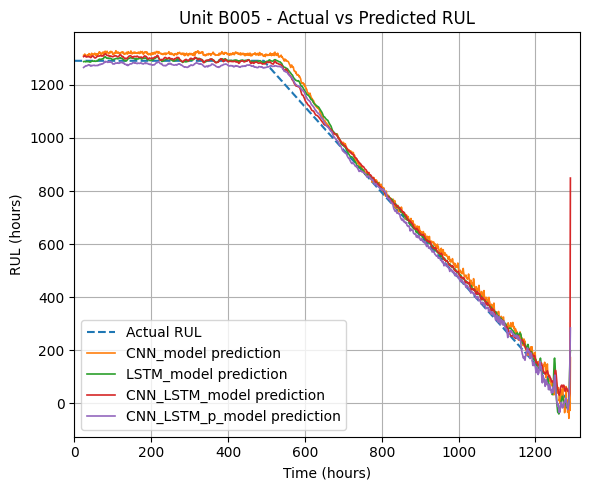

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


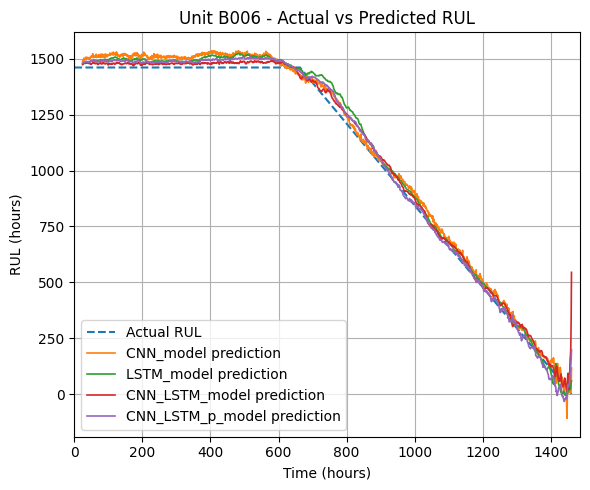

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


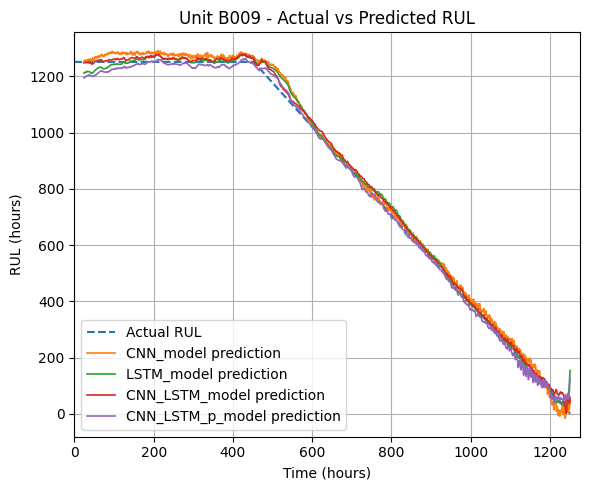

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TEST UNITS
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


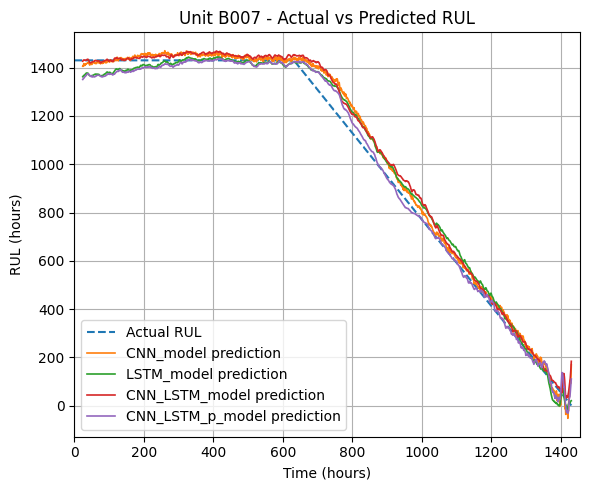

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


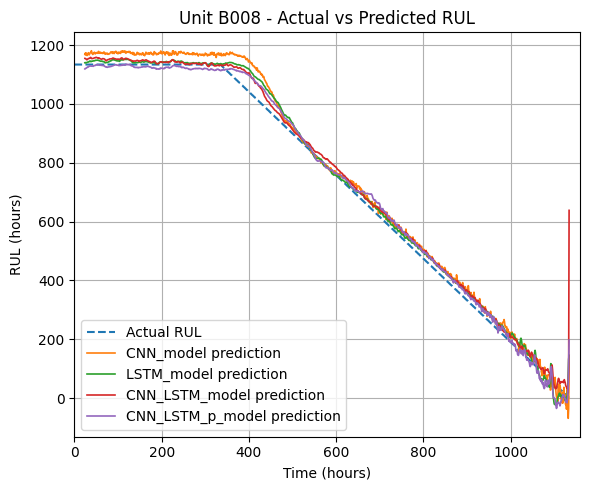

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


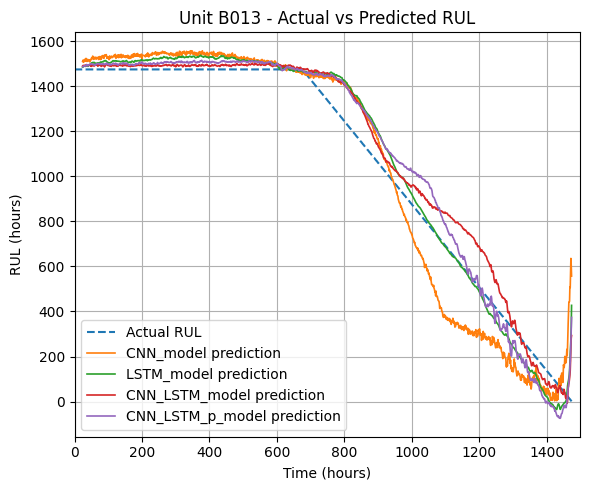

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


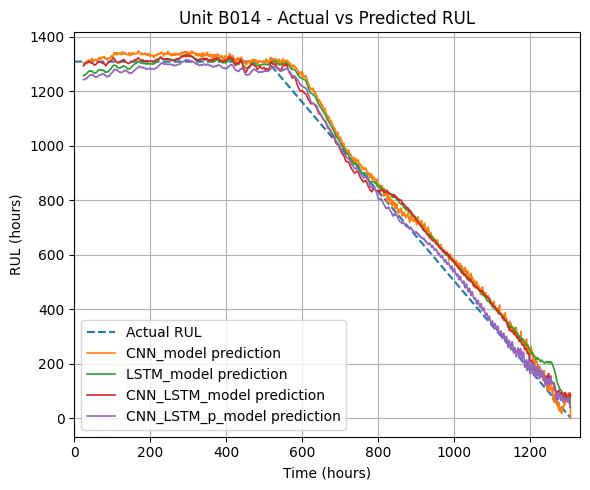

In [55]:
escenario = 1
win_length = 24
test_units = df[df['unit_id'].isin(escenarios[escenario]['test_units'])].reset_index(drop=True)
train_units = df[df['unit_id'].isin(escenarios[escenario]['train_units'])].reset_index(drop=True)

CNN_model = load_model(f'models/CNN_model_{str(escenario)}.keras')
LSTM_model = load_model(f'models/LSTM_model_{str(escenario)}.keras')
CNN_LSTM_model = load_model(f'models/CNN_LSTM_model_{str(escenario)}.keras')
CNN_LSTM_p_model = load_model(f'models/CNN_LSTM_p_model_{str(escenario)}.keras')

EOL = [1279, 1169, 1418, 1200, 1292, 1462, 1431, 1135, 1252, 1318, 1519, 1431, 1475, 1309]
ts = [479, 370, 619, 401, 493, 663, 632, 335, 453, 519, 719, 632, 676, 510]

if escenario == 1:
    EOL_train = [EOL[i] for i in [int(item[1:]) - 1 for item in escenarios[1]['train_units']]]
    EOL_test = [EOL[i] for i in [int(item[1:]) - 1 for item in escenarios[1]['test_units']]]
else:
    EOL_train = [EOL[i] for i in [int(item[1:]) - 1 for item in escenarios[2]['train_units']]]
    EOL_test = [EOL[i] for i in [int(item[1:]) - 1 for item in escenarios[2]['test_units']]]

print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TRAIN UNITS')
units = train_units['unit_id'].unique()
for i in range(len(units)):
    evaluation_model(train_units, units[i], escenario , EOL_train[i])
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TEST UNITS')
units = test_units['unit_id'].unique()
for i in range(len(units)):
    evaluation_model(test_units, units[i], escenario , EOL_test[i])

## Función para generar histogramas de error

In [73]:
def error_model(model, df, esc):
    models = {
        CNN_model:'CNN_model',
        LSTM_model:'LSTM_model',
        CNN_LSTM_model:'CNN_LSTM_model',
        CNN_LSTM_p_model: 'CNN_LSTM_p_model'
    }
    units = df['unit_id'].unique()
    actual_RUL = pd.DataFrame()
    pred_RUL = pd.DataFrame()
    for i, unit in enumerate(units):
        unit_data = df[df['unit_id']==unit].iloc[:, 2:]
        features, target, scaler = Scaler(unit_data)
        x, y = Sliding_Window(features, target, win_length)
        y_pred = model.predict(x)
        df_actual = unit_data.reset_index(drop=True)
        rev_trans = pd.concat([pd.DataFrame(features[win_length:]), pd.DataFrame(y_pred)], axis=1)
        rev_trans = scaler.inverse_transform(rev_trans)
        rev_trans = pd.DataFrame(rev_trans, columns=df_actual.columns.to_list())
        rev_trans.index = pd.RangeIndex(start=win_length, stop=len(df_actual))
        actual_RUL = pd.concat([actual_RUL, df_actual.iloc[win_length:]['RUL']], axis=0).reset_index(drop=True)
        pred_RUL = pd.concat([pred_RUL, rev_trans['RUL']], axis=0).reset_index(drop=True)

    error = actual_RUL - pred_RUL
    mae = mean_absolute_error(actual_RUL, pred_RUL)
    mse = mean_squared_error(actual_RUL, pred_RUL)
    mape = np.mean(np.abs((actual_RUL - pred_RUL) / actual_RUL)) * 100
    rmse = np.sqrt(mean_squared_error(actual_RUL, pred_RUL))
    r2 = r2_score(actual_RUL, pred_RUL)
    
    fig, ax1 = plt.subplots(figsize=(6, 5))
    ax1.hist(error, bins=15, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Histogram of Prediction Error - {models[model]}')
    text_box = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}\nR2: {r2:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.96, text_box, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props) #0.73

    ax2 = ax1.twinx()
    kde_data = sns.kdeplot(error, ax=ax2, linewidth=1.5, legend=False).get_lines()[0].get_data()
    ax2.fill_between(kde_data[0], kde_data[1], color='red', alpha=0.2)  # Ajusta la opacidad con el parámetro 'alpha'
    ax2.get_yaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.savefig(f'images/histogram_{str(esc)}_{models[model]}.png', format='png', dpi=300)
    plt.show()

<>:33: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Pablo Ignacio\AppData\Local\Temp\ipykernel_14000\2099130310.py:33: SyntaxWarning: invalid escape sequence '\w'
  ax1.set_xlabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')


Para evaluar el desempeño de las unidades en el escenario 2, es necesario modificar la variable ``escenario`` en ``1`` o ``2`` dependiendo del caso.

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TRAIN UNITS
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


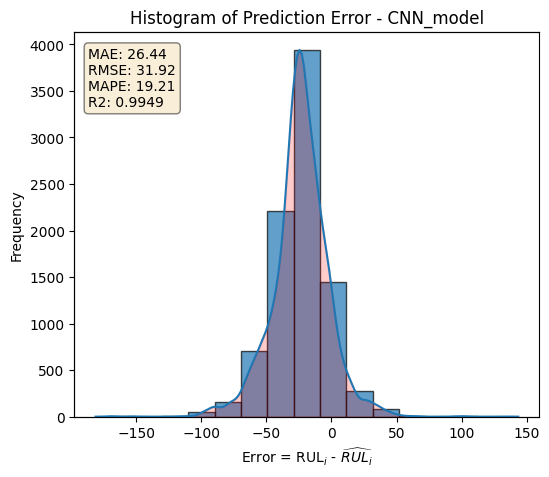

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


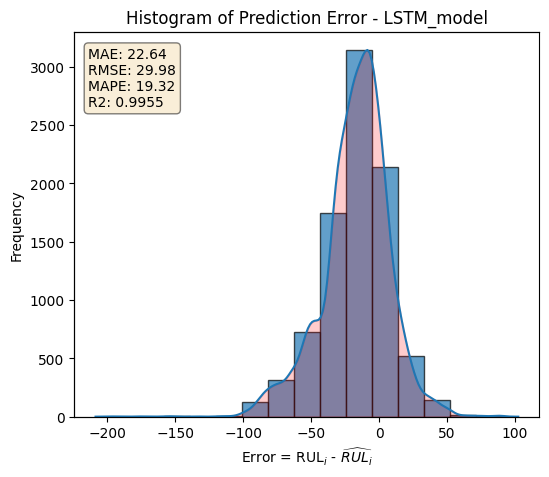

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


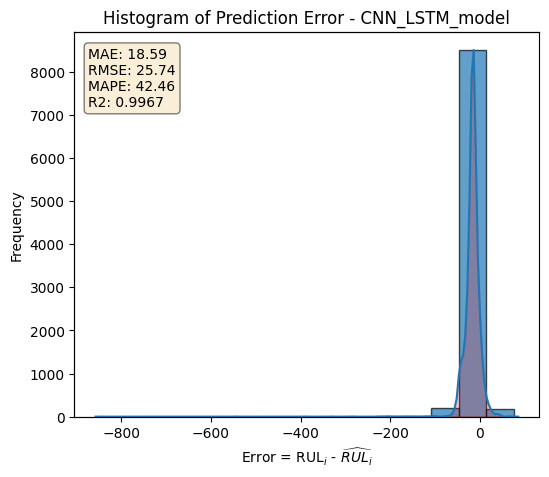

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


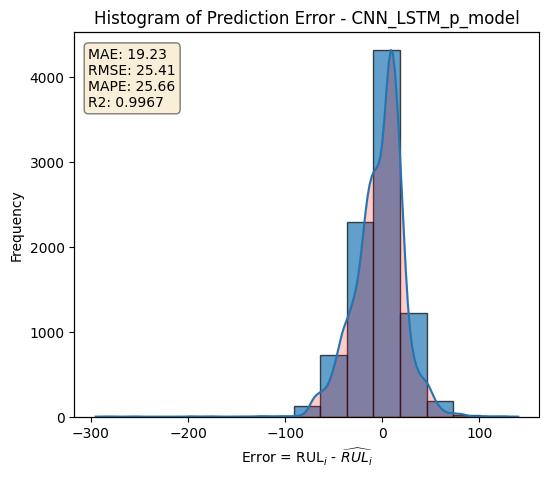

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TEST UNITS
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


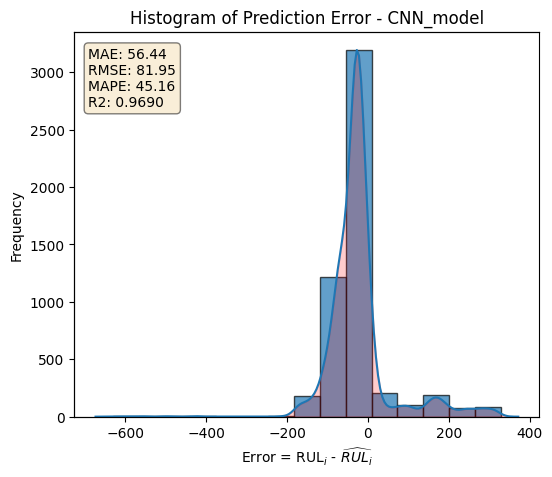

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


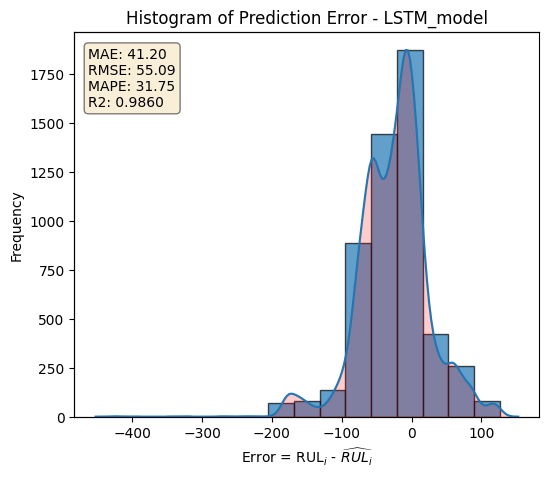

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


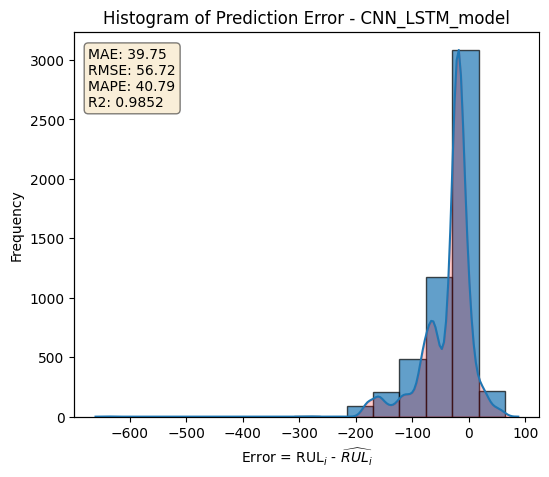

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


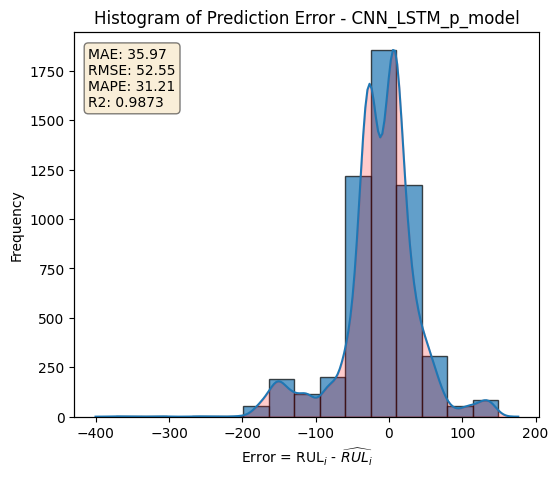

In [74]:
escenario = 1
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TRAIN UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    error_model(model, train_units, escenario)
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TEST UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    error_model(model, test_units, escenario)

## Boxplot de los errores de predicción

In [77]:
def boxplot_error(model, df, esc):
    models = {
        CNN_model:'CNN_model',
        LSTM_model:'LSTM_model',
        CNN_LSTM_model:'CNN_LSTM_model',
        CNN_LSTM_p_model: 'CNN_LSTM_p_model'
    }
    units = df['unit_id'].unique()
    actual_RUL = pd.DataFrame()
    pred_RUL = pd.DataFrame()
    error_dist = []
    for i, unit in enumerate(units):
        unit_data = df[df['unit_id']==unit].iloc[:, 2:]
        features, target, scaler = Scaler(unit_data)
        x, y = Sliding_Window(features, target, win_length)
        y_pred = model.predict(x)
        df_actual = unit_data.reset_index(drop=True)
        rev_trans = pd.concat([pd.DataFrame(features[win_length:]), pd.DataFrame(y_pred)], axis=1)
        rev_trans = scaler.inverse_transform(rev_trans)
        rev_trans = pd.DataFrame(rev_trans, columns=df_actual.columns.to_list())
        rev_trans.index = pd.RangeIndex(start=win_length, stop=len(df_actual))
        actual_RUL = pd.concat([actual_RUL, df_actual.iloc[win_length:]['RUL']], axis=0).reset_index(drop=True)
        pred_RUL = pd.concat([pred_RUL, rev_trans['RUL']], axis=0).reset_index(drop=True)

        error = np.array(actual_RUL - pred_RUL).flatten()
        error_dist.append(error)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.boxplot(error_dist)
    ax.set_xticklabels(units)
    ax.set_xlabel('Unidades')
    ax.set_ylabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')
    ax.set_ylim(-700, 500)
    plt.title(f'Boxplot of Prediction Error - {models[model]}')
    plt.savefig(f'images/boxplot_{str(esc)}_{models[model]}.png', format='png', dpi=300)  
    plt.show()

<>:31: SyntaxWarning: invalid escape sequence '\w'
<>:31: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Pablo Ignacio\AppData\Local\Temp\ipykernel_14000\819712252.py:31: SyntaxWarning: invalid escape sequence '\w'
  ax.set_ylabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')


---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TRAIN UNITS
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


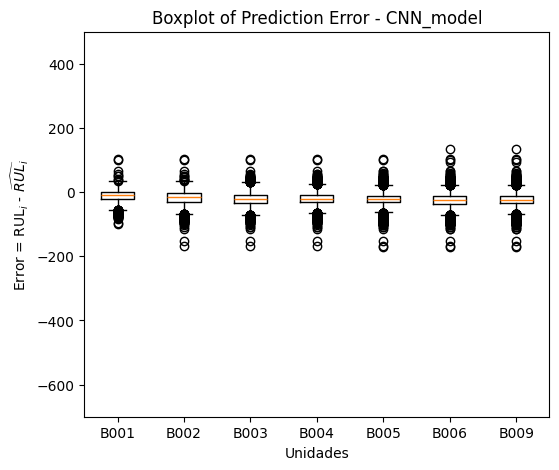

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


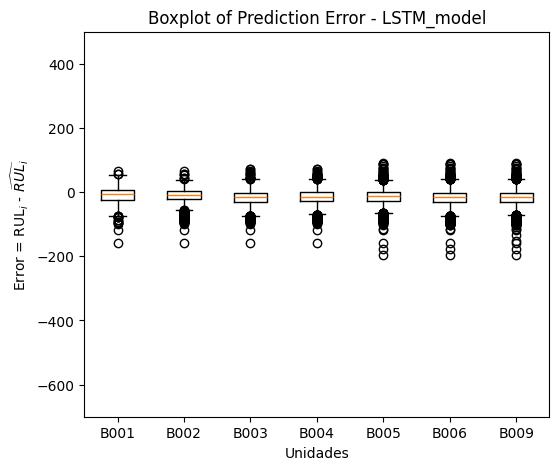

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


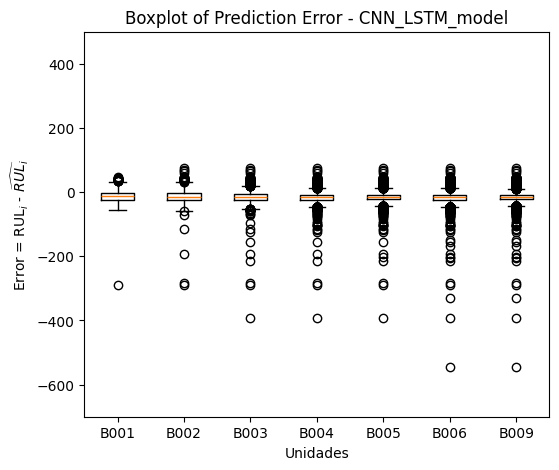

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


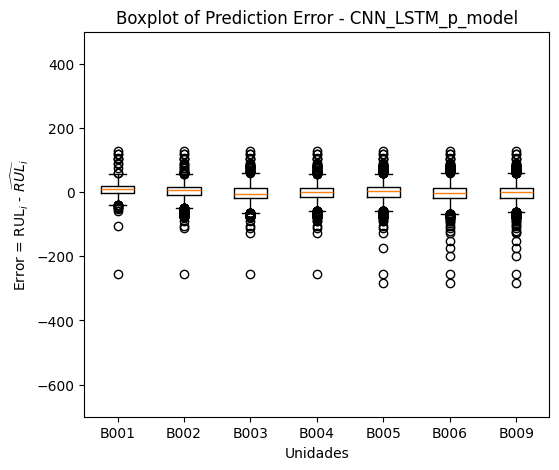

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TEST UNITS
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


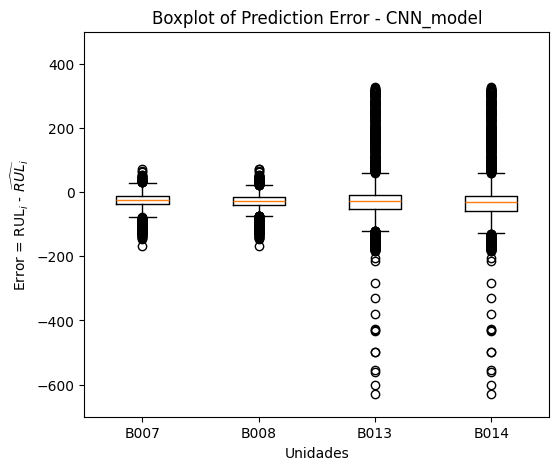

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


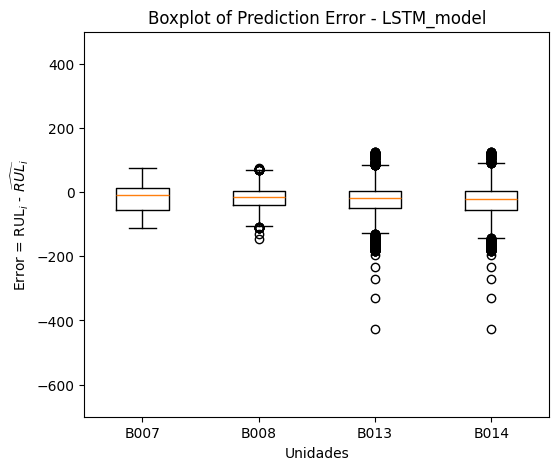

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


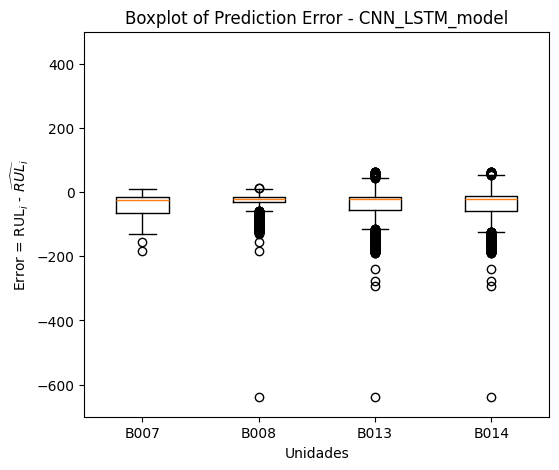

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


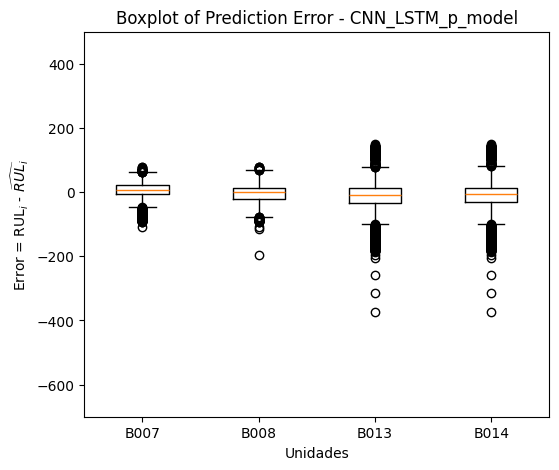

In [78]:
escenario = 1
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TRAIN UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    boxplot_error(model, train_units, escenario)
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TEST UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    boxplot_error(model, test_units, escenario)

## Gráficos de residuos de los errores de predicción

In [81]:
def plotting_residuals(model, df, esc):
    models = {
        CNN_model:'CNN_model',
        LSTM_model:'LSTM_model',
        CNN_LSTM_model:'CNN_LSTM_model',
        CNN_LSTM_p_model: 'CNN_LSTM_p_model'
    }
    units = df['unit_id'].unique()
    actual_RUL = pd.DataFrame()
    pred_RUL = pd.DataFrame()
    final = []

    for i, unit in enumerate(units):
        unit_data = df[df['unit_id']==unit].iloc[:, 2:]
        features, target, scaler = Scaler(unit_data)
        x, y = Sliding_Window(features, target, win_length)
        y_pred = model.predict(x)
        df_actual = unit_data.reset_index(drop=True)
        rev_trans = pd.concat([pd.DataFrame(features[win_length:]), pd.DataFrame(y_pred)], axis=1)
        rev_trans = scaler.inverse_transform(rev_trans)
        rev_trans = pd.DataFrame(rev_trans, columns=df_actual.columns.to_list())
        rev_trans.index = pd.RangeIndex(start=win_length, stop=len(df_actual))
        actual_RUL = pd.concat([actual_RUL, df_actual.iloc[win_length:]['RUL']], axis=0).reset_index(drop=True)
        pred_RUL = pd.concat([pred_RUL, rev_trans['RUL']], axis=0).reset_index(drop=True)
        final.append(len(actual_RUL))
        
    residuals = actual_RUL - pred_RUL
    plt.figure(figsize=(6, 5))
    plt.scatter(range(len(residuals)), residuals, alpha=0.6, s=10)
    plt.axhline(0, color='red', linestyle='-')
    plt.axvline(final[0], color='r', linestyle='--', linewidth=1)
    plt.axvline(final[1], color='r', linestyle='--', linewidth=1)
    plt.axvline(final[2], color='r', linestyle='--', linewidth=1)
    plt.axvline(final[3], color='r', linestyle='--', linewidth=1)

    """para que los cuadros que indican la unidad en las figuras queden mejor dispuestas, hay que modificar el valor de posición horixzontal de plt.gca().text(0.15.... """
    text_box = f'unit {units[0]}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.15, 0.95, text_box, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=props) #1, 0.15; 2, 0.14
    text_box = f'unit {units[1]}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.34, 0.95, text_box, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=props) #1, 0.34; 2, 0.34
    text_box = f'unit {units[2]}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.59, 0.95, text_box, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=props) #1, 0.59; 2, 0.57
    text_box = f'unit {units[3]}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.81, 0.95, text_box, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=props) #1, 0.81; 2, 0.81
    
    plt.xlabel('Index')
    plt.ylabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')
    plt.title(f'Residuals of Predictions - {models[model]}')
    plt.grid(True)
    plt.ylim(-400, 400)
    plt.savefig(f'images/residuals_{str(esc)}_{models[model]}.png', format='png', dpi=300)  
    plt.show()

<>:51: SyntaxWarning: invalid escape sequence '\w'
<>:51: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Pablo Ignacio\AppData\Local\Temp\ipykernel_14000\2818724429.py:51: SyntaxWarning: invalid escape sequence '\w'
  plt.ylabel('Error = RUL$_{i}$ - $\widehat{RUL}_{i}$')


---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TRAIN UNITS
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


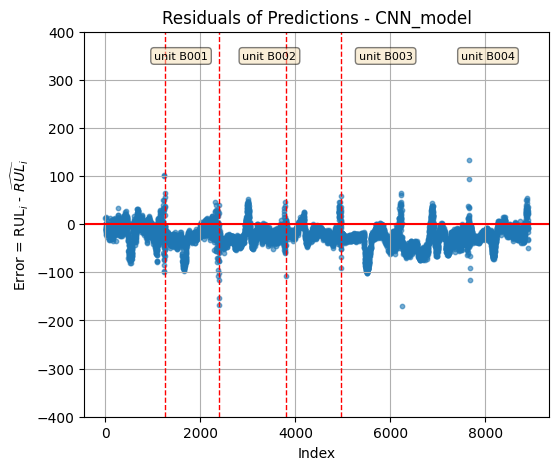

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


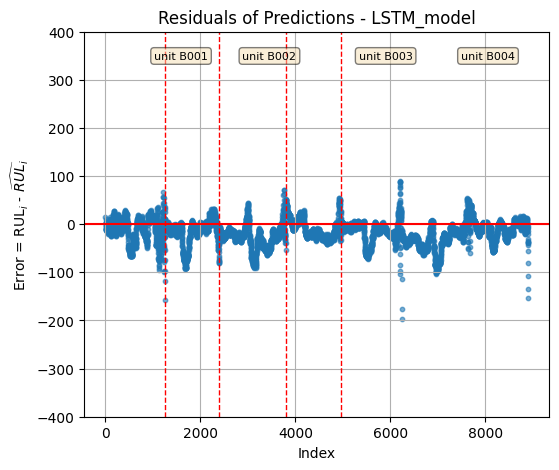

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


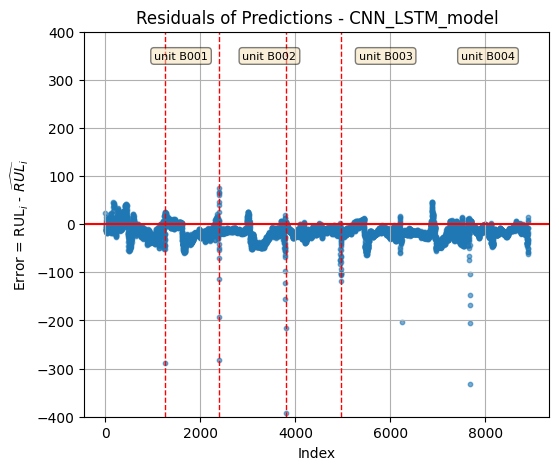

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


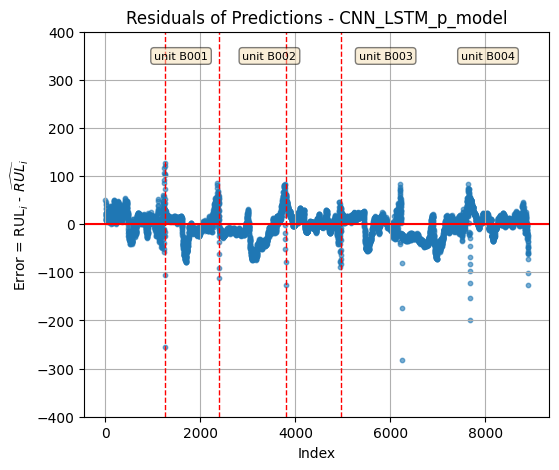

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
EVALUATION ON TEST UNITS
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


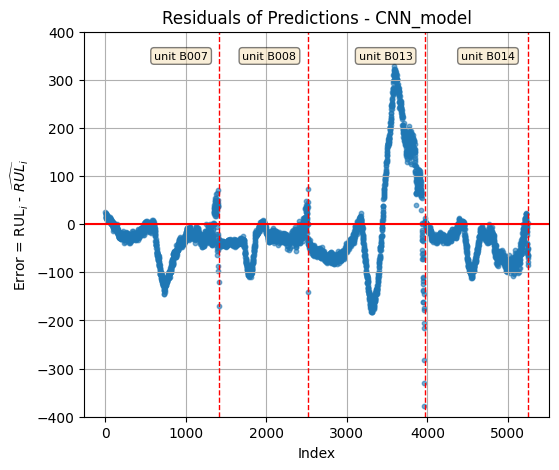

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


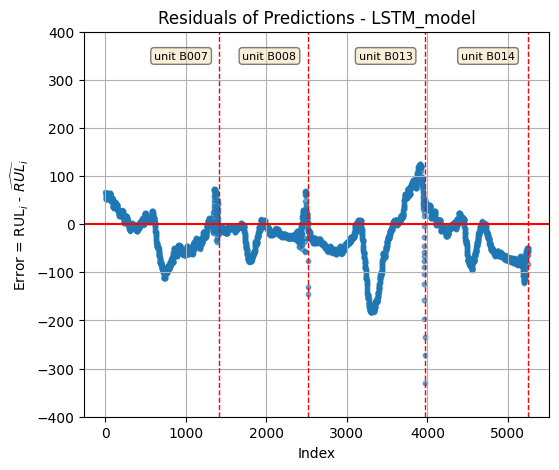

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


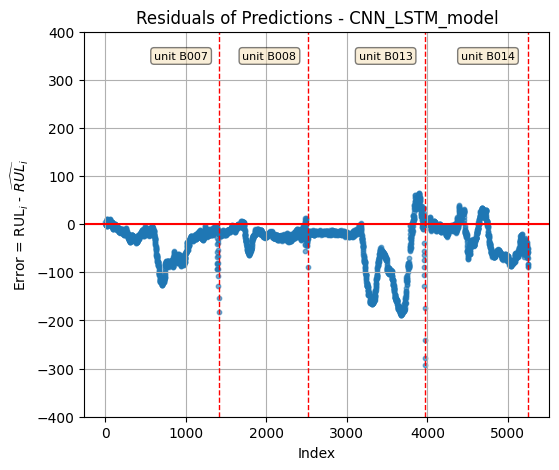

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


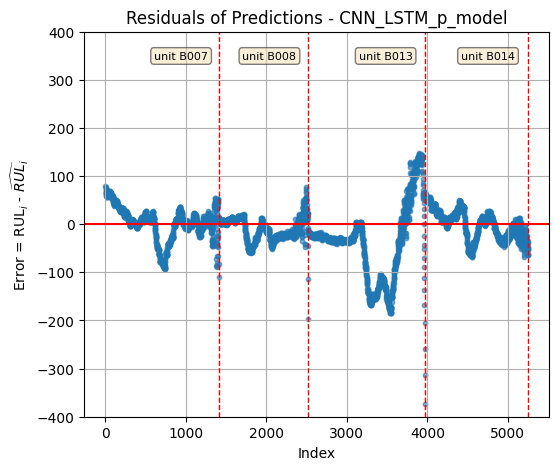

In [80]:
escenario = 1
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TRAIN UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    plotting_residuals(model, train_units, escenario)
print('---------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------')
print('EVALUATION ON TEST UNITS')
for model in [CNN_model, LSTM_model, CNN_LSTM_model, CNN_LSTM_p_model]:
    plotting_residuals(model, test_units, escenario)